In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.special import softmax, log_softmax
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils

from fitter import Fitter, get_common_distributions

from tqdm import tqdm
import random

# Import P(f_i | C) distributions

In [2]:
#import best fitting distributions and parameters

feature_dists_df = pd.read_csv('feature_dists_df.csv').drop(['Unnamed: 0'], axis=1)
feature_dists_df

,feature,distribution_type,params,label
0,feature_2,beta,"(0.11776839045890578, 149.74182795203535, -2.1...",5
1,feature_4,beta,"(0.2711632488092937, 465.4069516854168, -1.928...",5
2,feature_5,beta,"(0.21602060508177978, 625.918439600516, -4.846...",5
3,feature_6,beta,"(14.256280670273213, 6.9058459231954, 1.454610...",5
4,feature_7,beta,"(0.4894176208554678, 528.8948875881285, -8.432...",5
5,feature_8,beta,"(0.11519992942043017, 197.06722892055205, -4.6...",5
6,feature_9,beta,"(0.3018378051146521, 204.95938188638956, -5.83...",5
7,feature_10,beta,"(14.752993151276618, 6.344337461684533, 0.1954...",5
8,feature_2,beta,"(14.821670613196302, 7.86665989995932, -6.5503...",8
9,feature_4,beta,"(16.236326591296894, 5.212638487058973, -7.674...",8


In [3]:
#create RV objects and store in dicts

feature_dists_5 = {}
feature_dists_8 = {}

for row in feature_dists_df.iterrows():
    row = row[1]
    
    #convert params string into tuple of floats
    params = tuple(map(float, row['params'][1:-1].split(', ')))
    
    #initialize RV objects
    if row['distribution_type']=='beta':
        dist = stats.beta(params[0], params[1], params[2], params[3])
    elif row['distribution_type']=='chi2':
        dist = stats.chi2(params[0], params[1], params[2])
    else:
        print('INVALID DISTRIBUTION TYPE')
        break
    
    #store RV objects in dicts
    if row['label'] == 5:
        feature_dists_5[row['feature']] = dist
    else:
        feature_dists_8[row['feature']] = dist


In [4]:
feature_dists_5

{'feature_2': <scipy.stats._distn_infrastructure.rv_frozen at 0x7feadcbe2280>,
 'feature_4': <scipy.stats._distn_infrastructure.rv_frozen at 0x7feadcbe2160>,
 'feature_5': <scipy.stats._distn_infrastructure.rv_frozen at 0x7feadcbe2670>,
 'feature_6': <scipy.stats._distn_infrastructure.rv_frozen at 0x7feadcbe2970>,
 'feature_7': <scipy.stats._distn_infrastructure.rv_frozen at 0x7feadcbe2cd0>,
 'feature_8': <scipy.stats._distn_infrastructure.rv_frozen at 0x7feadcbe2130>,
 'feature_9': <scipy.stats._distn_infrastructure.rv_frozen at 0x7feadcbe2250>,
 'feature_10': <scipy.stats._distn_infrastructure.rv_frozen at 0x7feadcbe20d0>}

# Get P(f_i) distributions

In [5]:
#import training feature value distributions
train_feature_vals_df = pd.read_csv('hidden_features_df.csv', index_col="Unnamed: 0")
train_feature_vals_df.head()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,8,0.0,11.246423,0.0,7.995950,9.410959,19.745337,9.010060,8.527996,10.110795,19.589340
1,8,0.0,13.312637,0.0,10.743755,11.378502,18.715256,11.810072,11.065614,12.528616,18.708977
2,5,0.0,0.000000,0.0,0.000000,0.000000,28.648830,0.000000,0.000000,0.000000,30.524609
3,5,0.0,0.000000,0.0,0.000000,0.000000,26.991035,0.000000,0.000000,0.000000,29.041384
4,8,0.0,5.038842,0.0,5.323320,5.368689,22.266983,4.806798,4.124915,4.903548,23.818264


In [6]:
# checking if feature_1 and feature_3 have all zeros
counts_feature1 = train_feature_vals_df.groupby('feature_1')['feature_1'].value_counts()
print(counts_feature1)

counts_feature3 = train_feature_vals_df.groupby('feature_3')['feature_3'].value_counts()
print(counts_feature3)

feature_1  feature_1
0.0        0.0          9370
Name: feature_1, dtype: int64
feature_3  feature_3
0.0        0.0          9370
Name: feature_3, dtype: int64


In [7]:
# dropping feature_1 and feature_3
train_feature_vals_df.drop(['feature_1', 'feature_3'], axis=1, inplace=True)

In [8]:
train_feature_vals_df.head()

,label,feature_2,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,8,11.246423,7.995950,9.410959,19.745337,9.010060,8.527996,10.110795,19.589340
1,8,13.312637,10.743755,11.378502,18.715256,11.810072,11.065614,12.528616,18.708977
2,5,0.000000,0.000000,0.000000,28.648830,0.000000,0.000000,0.000000,30.524609
3,5,0.000000,0.000000,0.000000,26.991035,0.000000,0.000000,0.000000,29.041384
4,8,5.038842,5.323320,5.368689,22.266983,4.806798,4.124915,4.903548,23.818264


In [9]:
#store histograms for each feature in dict
hist_dict = {}

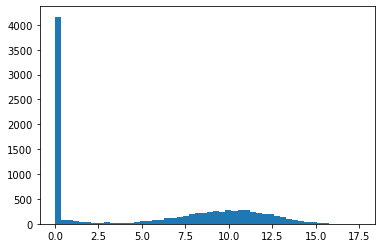

In [10]:
#fit distributionn for feature 2

feature_2 = train_feature_vals_df['feature_2']
feature_2_hist = plt.hist(feature_2, bins=50)
feature_2_hist

#add histogram to hist_dict
hist_dict['feature_2'] = feature_2_hist

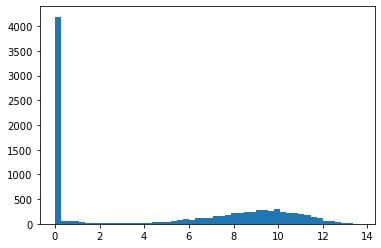

In [11]:
#fit distributionn for feature 4

feature_4 = train_feature_vals_df['feature_4']
feature_4_hist = plt.hist(feature_4, bins=50)
feature_4_hist

#add histogram to hist_dict
hist_dict['feature_4'] = feature_4_hist

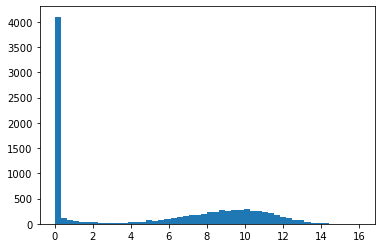

In [12]:
#fit distributionn for feature 5

feature_5 = train_feature_vals_df['feature_5']
feature_5_hist = plt.hist(feature_5, bins=50)
feature_5_hist

#add histogram to hist_dict
hist_dict['feature_5'] = feature_5_hist

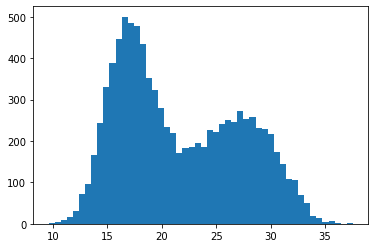

In [13]:
#fit distributionn for feature 6

feature_6 = train_feature_vals_df['feature_6']
feature_6_hist = plt.hist(feature_6, bins=50)
feature_6_hist

#add histogram to hist_dict
hist_dict['feature_6'] = feature_6_hist

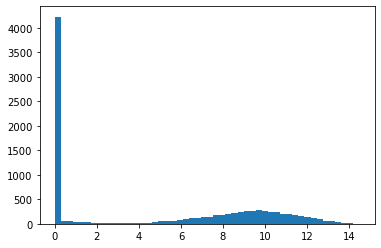

In [14]:
#fit distributionn for feature 7

feature_7 = train_feature_vals_df['feature_7']
feature_7_hist = plt.hist(feature_7, bins=50)
feature_7_hist

#add histogram to hist_dict
hist_dict['feature_7'] = feature_7_hist

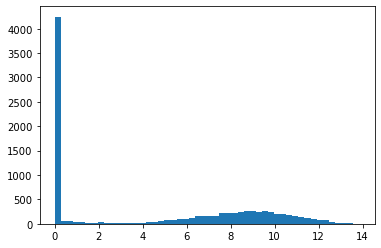

In [15]:
#fit distributionn for feature 8

feature_8 = train_feature_vals_df['feature_8']
feature_8_hist = plt.hist(feature_8, bins=50)
feature_8_hist

#add histogram to hist_dict
hist_dict['feature_8'] = feature_8_hist

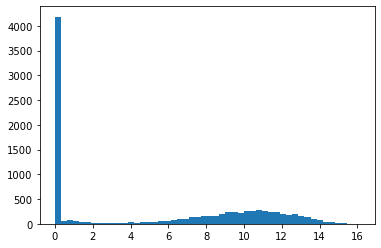

In [16]:
#fit distributionn for feature 9

feature_9 = train_feature_vals_df['feature_9']
feature_9_hist = plt.hist(feature_9, bins=50)
feature_9_hist

#add histogram to hist_dict
hist_dict['feature_9'] = feature_9_hist

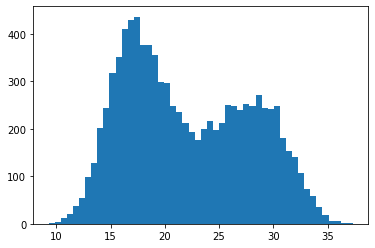

In [17]:
#fit distributionn for feature 10

feature_10 = train_feature_vals_df['feature_10']
feature_10_hist = plt.hist(feature_10, bins=50)
feature_10_hist

#add histogram to hist_dict
hist_dict['feature_10'] = feature_10_hist

# Define Bayesian Model

In [18]:
hist_dict['feature_2'][0]

array([4.163e+03, 7.900e+01, 7.000e+01, 5.500e+01, 3.200e+01, 3.100e+01,
       2.500e+01, 2.100e+01, 2.800e+01, 2.300e+01, 2.100e+01, 1.900e+01,
       2.500e+01, 4.100e+01, 4.900e+01, 6.300e+01, 8.100e+01, 7.200e+01,
       1.140e+02, 1.230e+02, 1.460e+02, 1.530e+02, 1.890e+02, 2.080e+02,
       2.130e+02, 2.430e+02, 2.580e+02, 2.330e+02, 2.850e+02, 2.500e+02,
       2.830e+02, 2.750e+02, 2.390e+02, 2.220e+02, 1.980e+02, 1.920e+02,
       1.560e+02, 1.430e+02, 1.040e+02, 7.600e+01, 5.500e+01, 4.000e+01,
       3.500e+01, 2.100e+01, 1.000e+01, 6.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00])

In [19]:
hist_dict['feature_2'][1]

array([ 0.        ,  0.34998878,  0.69997757,  1.04996635,  1.39995514,
        1.74994392,  2.09993271,  2.44992149,  2.79991028,  3.14989906,
        3.49988785,  3.84987663,  4.19986542,  4.5498542 ,  4.89984299,
        5.24983177,  5.59982056,  5.94980934,  6.29979813,  6.64978691,
        6.9997757 ,  7.34976448,  7.69975327,  8.04974205,  8.39973083,
        8.74971962,  9.0997084 ,  9.44969719,  9.79968597, 10.14967476,
       10.49966354, 10.84965233, 11.19964111, 11.5496299 , 11.89961868,
       12.24960747, 12.59959625, 12.94958504, 13.29957382, 13.64956261,
       13.99955139, 14.34954018, 14.69952896, 15.04951775, 15.39950653,
       15.74949532, 16.0994841 , 16.44947289, 16.79946167, 17.14945045,
       17.49943924])

In [20]:
# define bayesian model
# input: feature values
# output: array of size 10x2 where element i is a size 2 array with values [P(5|f_i), P(8|f_i)]

def bayesian_model(feature_vals):
    
    output = np.empty([10,2])
    
    #define priors
    prior_5 = np.log(0.5)
    prior_8 = np.log(0.5)
    
    for i, val in enumerate(feature_vals):
        
        feature_num = i+1
        
        if feature_num==1 or feature_num==3:
            continue
            
        #get distribution (RV) objects
        dist_5 = feature_dists_5['feature_'+str(feature_num)]
        dist_8 = feature_dists_8['feature_'+str(feature_num)]
        
        #get likelihood (i.e. get log probability of value being between (int(val), int(val)+1))
        log_likelihood_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
        log_likelihood_8 = np.log(dist_8.cdf(int(val)+1) - dist_8.cdf(int(val)))
        
        #get P(f_i)
        hist = hist_dict['feature_'+str(feature_num)]
        hist_counts = hist[0]
        hist_bins = hist[1]
        
        for j, bin_val in enumerate(hist_bins):
            if j == 0:
                continue
            if val <= bin_val:
                log_prob_feature = np.log(hist_counts[j-1] / np.sum(hist_counts))
                break
        
        #compute posteriors
        posterior_5 = np.exp((prior_5 + log_likelihood_5) - log_prob_feature)
        posterior_8 = np.exp((prior_8 + log_likelihood_8) - log_prob_feature)
        
        output[i] = [posterior_5, posterior_8]
    
    return output

# Test Bayesian model

In [21]:
#import cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 10 channels in first convolution layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 20 channels in second conv. layer
        self.fc1 = nn.Linear(320, 10) # 10 hidden units in first fully-connected layer
        self.fc2 = nn.Linear(10, 2) # 2 output units

    def forward(self, x):

        # first convolutional layer
        h_conv1 = self.conv1(x)
        h_conv1 = F.relu(h_conv1)
        h_conv1_pool = F.max_pool2d(h_conv1, 2)

        # second convolutional layer
        h_conv2 = self.conv2(h_conv1_pool)
        h_conv2 = F.relu(h_conv2)
        h_conv2_pool = F.max_pool2d(h_conv2, 2)

        # fully-connected layer
        h_fc1 = h_conv2_pool.view(-1, 320)
        h_fc1 = self.fc1(h_fc1)
        h_fc1 = F.relu(h_fc1)
        
        # classifier output
        output = self.fc2(h_fc1)
        output = F.log_softmax(output,dim=1)
        return output, h_fc1

#load saved trained CNN model
cnn = CNN()
cnn.load_state_dict(torch.load('cnn'))
cnn.train(False)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [36]:
#import test dataset
# NOTE: test dataset is distorted with pytorch's Elastic Transform augmentation
test_dataset = datasets.MNIST(root='data',
                              train=False,
                              download=True,
                              transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              transforms.ElasticTransform(alpha=75.0, sigma=5.0)
                              ]))

#filter dataset to only 5's and 8's
test_filter = [idx for idx, sample in enumerate(test_dataset) if sample[1] in [5,8]]
test_dataset = torch.utils.data.Subset(test_dataset, test_filter)

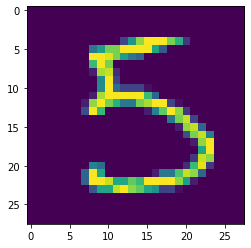

In [64]:
#visualize augmentation

unaugmented_dataset = datasets.MNIST(root='data',
                              train=False,
                              download=True,
                              transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                              ]))
unaugmented_dataset = torch.utils.data.Subset(unaugmented_dataset, test_filter)
image = unaugmented_dataset[1][0]
plt.imshow(image.detach(). permute(1,2,0))

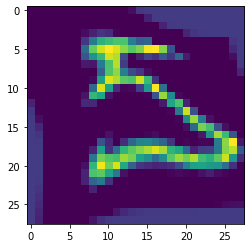

In [67]:
#visualize augmentation

from PIL import Image
transform=transforms.Compose([
                              #transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),
                              transforms.ElasticTransform(alpha=75.0, sigma=5.0)])

augmented_image = transform(image)
plt.imshow(augmented_image.detach().permute(1,2,0))

In [37]:
#test bayesian model on test set

num_correct = 0

for sample in tqdm(test_dataset):
    data = sample[0]
    label = sample[1]
    
    #extract features using CNN
    output, features = cnn(data)
    
    #get outputs from Bayesian model using extracted features
    bayes_out = bayesian_model(features.squeeze().detach().numpy())
    
    # get prediction by counting predictions by feature
    # if majority of features predict 5 then bayes prediction is 5. If majority predict 8 then bayes prediction is 8
    # in the event of a tie, choose randomly
    
    count_pred_5 = 0
    
    for feature_output in bayes_out:
        prob_5 = feature_output[0]
        prob_8 = feature_output[1]
        
        if prob_5 > prob_8:
            count_pred_5 += 1
    
    if count_pred_5 == 4:
        if random.random() < 0.5:
            bayes_pred = 5
        else:
            bayes_pred = 8
    elif count_pred_5 > 4:
        bayes_pred = 5
    else:
        bayes_pred = 8

    if bayes_pred == label:
        num_correct += 1

#compute test accuracy
test_acc = num_correct / len(test_dataset)

print('bayesian model test accuracy: {}'.format(test_acc))

  0%|          | 0/1866 [00:00<?, ?it/s]<ipython-input-20-561d9a36d565>:25: RuntimeWarning: divide by zero encountered in log
  log_likelihood_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
100%|██████████| 1866/1866 [00:17<00:00, 103.84it/s]

bayesian model test accuracy: 0.9158628081457664


In [38]:
out, features = cnn(test_dataset[0][0])
output = bayesian_model(features.squeeze().detach().numpy())
output

array([[0.00000000e+00, 0.00000000e+00],
       [1.12341490e+00, 2.46646178e-04],
       [0.00000000e+00, 0.00000000e+00],
       [1.11760467e+00, 2.60719020e-04],
       [1.14239684e+00, 3.74657611e-04],
       [8.99667027e-01, 6.37091946e-01],
       [1.10808893e+00, 1.51008176e-04],
       [1.10220833e+00, 1.16443760e-04],
       [1.11920685e+00, 2.82312433e-04],
       [3.83388953e-01, 1.16473669e+00]])

# Visualize magnet effect

In [39]:


#define bayesian model
#inputs: feature values
#outputs: P(I|5)*P(5), P(I|8)*P(8)

def bayesian_model_2(feature_vals):
    
    #define priors
    prior_5 = np.log(0.5)
    prior_8 = np.log(0.5)
    
    #compute P(I|C) likelihoods
    likelihood_5 = 0
    likelihood_8 = 0
    
    for i, val in enumerate(feature_vals):
        
        feature_num = i+1
        
        if feature_num==1 or feature_num==3:
            continue
            
        #get distribution (RV) objects
        dist_5 = feature_dists_5['feature_'+str(feature_num)]
        dist_8 = feature_dists_8['feature_'+str(feature_num)]
        
        #get log probability of value being between (int(val), int(val)+1)
        log_prob_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
        log_prob_8 = np.log(dist_8.cdf(int(val)+1) - dist_8.cdf(int(val)))
        
        #update likelihoods
        likelihood_5 += log_prob_5
        likelihood_8 += log_prob_8
        
    #get P(I) = P(I|5)*P(5) + P(I|8)*P(8)
    prob_features_5 = np.exp(likelihood_5 + prior_5)
    prob_features_8 = np.exp(likelihood_8 + prior_8)
    prob_features = np.log(prob_features_5 + prob_features_8)
    
    output_5 = np.exp(prior_5 + likelihood_5 - prob_features)
    output_8 = np.exp(prior_8 + likelihood_8 - prob_features)
    
    
    return output_5, output_8
    

In [40]:


#test bayesian model on test set

num_correct = 0

for sample in tqdm(test_dataset):
    data = sample[0]
    label = sample[1]
    
    #extract features using CNN
    output, features = cnn(data)
    
    #get outputs from Bayesian model using extracted features
    bayesian_out_5, bayesian_out_8 = bayesian_model_2(features.squeeze().detach().numpy())
    
    if bayesian_out_5 > bayesian_out_8:
        bayesian_pred = 5
    else:
        bayesian_pred = 8

    if bayesian_pred == label:
        num_correct += 1

#compute test accuracy
test_acc = num_correct / len(test_dataset)

print('bayesian model test accuracy: {}'.format(test_acc))

  0%|          | 0/1866 [00:00<?, ?it/s]<ipython-input-39-68b525074d66>:30: RuntimeWarning: divide by zero encountered in log
  log_prob_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
100%|██████████| 1866/1866 [00:18<00:00, 100.57it/s]

bayesian model test accuracy: 0.9180064308681672


In [45]:


from tqdm import tqdm

comparison_results = np.empty([len(test_dataset),2])

for i, sample in tqdm(enumerate(test_dataset)):
    data = sample[0]
    label = sample[1]
    
    #extract features using CNN
    cnn_output, features = cnn(data)
    
    cnn_output = cnn_output.squeeze().detach().numpy()
    
    #get outputs from Bayesian model using extracted features
    bayes_output = bayesian_model_2(features.squeeze().detach().numpy())
    #print(bayes_output)
    #bayes_out_softmax = softmax(bayes_output)
    #print(bayes_out_softmax)
    
    if label == 5:
        bayes_result = bayes_output[0]
        cnn_result = np.exp(cnn_output[0])
    else:
        bayes_result = bayes_output[1]
        cnn_result = np.exp(cnn_output[1])
    
    
    comparison_results[i] = [cnn_result, bayes_result]



7it [00:00, 61.29it/s]<ipython-input-39-68b525074d66>:30: RuntimeWarning: divide by zero encountered in log
  log_prob_5 = np.log(dist_5.cdf(int(val)+1) - dist_5.cdf(int(val)))
1866it [00:15, 123.15it/s]


(array([  16.,   16.,   16.,   14.,   10.,   11.,   15.,   29.,   51.,
        1688.]),
 array([0.00218535, 0.10196681, 0.20174828, 0.30152974, 0.40131121,
        0.50109267, 0.60087414, 0.7006556 , 0.80043707, 0.90021853,
        1.        ]),
 <BarContainer object of 10 artists>)

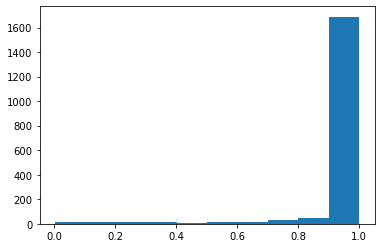

In [52]:
plt.hist(comparison_results[:,0], bins=10)

(array([1.550e+02, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 1.703e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

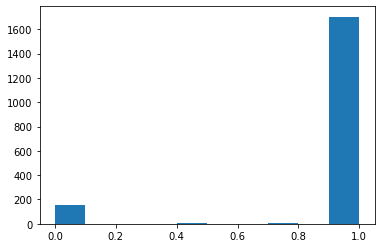

In [53]:
plt.hist(comparison_results[:,1], bins=10)